In [1]:
import pandas as pd

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score, average_precision_score
from sklearn.metrics import f1_score
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
import pylab 
import scipy.stats as stats
import datetime

from scipy import stats
from scipy.stats import norm, skew #for some statistics

# ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('Laptop_price.csv')


In [3]:
train_df.head()

,Brand,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
0,Asus,3.830296,16,512,11.185147,2.641094,17395.093065
1,Acer,2.912833,4,1000,11.311372,3.260012,31607.605919
2,Lenovo,3.241627,4,256,11.853023,2.029061,9291.023542
3,Acer,3.806248,16,512,12.280360,4.573865,17436.728334
4,Acer,3.268097,32,1000,14.990877,4.193472,32917.990718


In [4]:
train_df.describe()

,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.750611,15.500000,584.576000,14.056790,3.466919,19604.187963
std,0.731796,10.988665,313.438517,1.705882,0.866541,9406.064880
min,1.511580,4.000000,256.000000,11.012111,2.000560,8570.012950
25%,2.089246,8.000000,256.000000,12.635523,2.717211,10114.012948
50%,2.760885,16.000000,512.000000,14.099643,3.464630,17287.241878
75%,3.362610,32.000000,1000.000000,15.528590,4.212583,31566.214754
max,3.998534,32.000000,1000.000000,16.985737,4.990728,33503.935037


### Target encoding

In [14]:
brand_target_mean = train_df.groupby('Brand')['Price'].mean()

train_df['Brand_encoded'] = train_df['Brand'].map(brand_target_mean)
train_df = train_df.drop('Brand', axis=1)

In [15]:
train_df.head()

,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price,Brand_encoded
0,3.830296,16,512,11.185147,2.641094,17395.093065,19854.238277
1,2.912833,4,1000,11.311372,3.260012,31607.605919,19984.613620
2,3.241627,4,256,11.853023,2.029061,9291.023542,19974.929725
3,3.806248,16,512,12.280360,4.573865,17436.728334,19984.613620
4,3.268097,32,1000,14.990877,4.193472,32917.990718,19984.613620


In [24]:
np.log2(1000)

9.965784284662087

(array([355.,   2.,   0., 296.,  11.,   0.,   0.,   0.,   4., 332.]),
 array([ 8570.01295047, 11063.40515915, 13556.79736784, 16050.18957652,
        18543.58178521, 21036.97399389, 23530.36620258, 26023.75841126,
        28517.15061995, 31010.54282863, 33503.93503731]),
 <BarContainer object of 10 artists>)

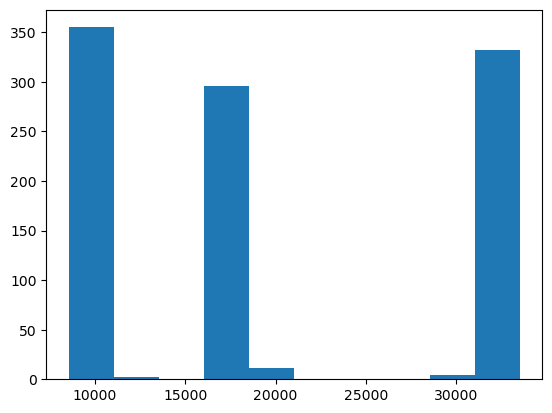

In [26]:
plt.hist(train_df.Price, bins=int(np.log2(1000) + 1))

{'whiskers': [<matplotlib.lines.Line2D at 0x251058ca610>,
 'caps': [<matplotlib.lines.Line2D at 0x251099d54d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x251099cd090>],
 'medians': [<matplotlib.lines.Line2D at 0x251099d6210>],
 'fliers': [<matplotlib.lines.Line2D at 0x251099d6c10>],
 'means': []}

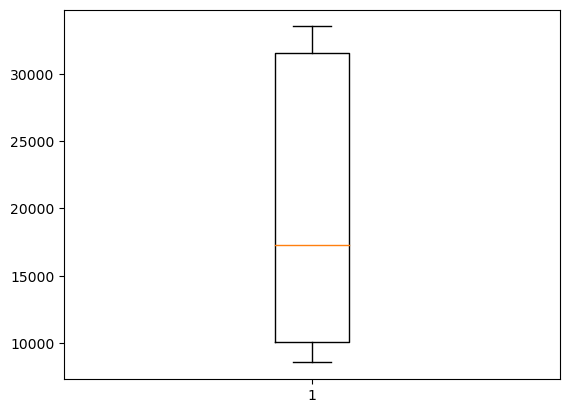

In [27]:
plt.boxplot(train_df.Price)

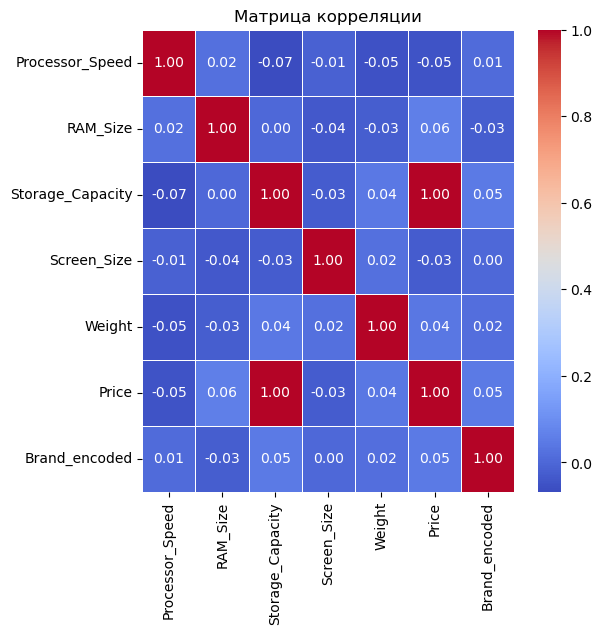

In [20]:
corr_matrix = train_df.corr()

plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

In [21]:
train_df.corr()

,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price,Brand_encoded
Processor_Speed,1.000000,0.021391,-0.067576,-0.013425,-0.054603,-0.050737,0.010893
RAM_Size,0.021391,1.000000,0.002111,-0.036002,-0.025382,0.061237,-0.025871
Storage_Capacity,-0.067576,0.002111,1.000000,-0.027560,0.041335,0.997908,0.047407
Screen_Size,-0.013425,-0.036002,-0.027560,1.000000,0.021995,-0.026740,0.001936
Weight,-0.054603,-0.025382,0.041335,0.021995,1.000000,0.038417,0.018861
Price,-0.050737,0.061237,0.997908,-0.026740,0.038417,1.000000,0.046776
Brand_encoded,0.010893,-0.025871,0.047407,0.001936,0.018861,0.046776,1.000000


### Gain Ratio = Information Gain / Split Info = (|X| * H(X) - |X_l| * H(X_l) - |X_r| * H(X_r))

In [33]:
from sklearn.feature_selection import mutual_info_regression

In [37]:
dict(zip(train_df.columns.drop('Price'), mutual_info_regression(train_df.drop('Price', axis=1), train_df.Price)))

{'Processor_Speed': 0.10307269870506097,
 'RAM_Size': 0.813194143489659,
 'Storage_Capacity': 1.0977126661825447,
 'Screen_Size': 0.0,
 'Weight': 0.0,
 'Brand_encoded': 0.033321691746451165}